# 5. Use Case on Network Distance

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks, see [https://github.com/mb-BCA/SiReNetA_Tutorials](https://github.com/mb-BCA/SiReNetA_Tutorials).

---------------------

### Outline of use case
* Concept of time-to-time distance for leaky cascade on a binary graph.
* Show the equivalence between graph distance for discrete cascade and time-to-peak distance for leaky cascade for several types of binary graphs.

See also notebook [2024Chaos\_Fig4\_NetDistance.ipynb](../Reproduce_Papers/2024Chaos_Fig4_NetDistance.ipynb).

---------------------

## Import libraries

In [1]:
# Python standard and third-party library imports

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import sireneta as sna

import galib.models 
import galib.tools

## 0. Theory based on leaky cascade

The continuous leaky cascade model for a connectivity $A$ gives the following response in matrix form: 
$$ R(t) = e^{J t} - e^{J^0 t}$$
where $J^0 = -\frac{1}{\tau} I$ is a diagonal matrix with $\tau$ the leakage time-constant and the Jacobian is $J = J^0 + A$, meaning the same diagonal matrix plus the connectivity as off-diagonal elements. 

In [Zamora-López and Gilson](https://doi.org/10.1063/5.0202241), we have shown that the time to peak provides an approximation for the geodesic distance, which we reproduce here briefly before illustrating it numerically. The key is that the derivative of the response can be used to evaluate the time-to-peak (where it becomes becomes zero). We denote it by $t^*$ for a given target/source pair fo nodes $(i, j)$ and we have $ R'_{ij}(t^*) = 0 $ that leads to
$$ [ e^{A t^*} ]_{ij} = [ (1 - \tau A )^{-1} ]_{ij} $$
where we have used the fact that $J^0$ is the identity matrix rescale by $1 / \tau$, meaning that it commutes with $A$ and we can separate it from the matrix exponental as a scalar factor. From here we express the matrix exponential and the matrix inverse as power series, focusing on the term $(i,j)$ of the exponent of matrix $A$
$$ \sum_{k \geq 0} \frac{(t^*)^k}{k!} [A^k]_{ij} = \sum_k (\tau)^k [A^k]_{ij} $$
Then the key is to see that until the shortest path length $k^*$ (corresponding to the geodesic distance) is reached, for all $k < k^*$ the term $[A^k]_{ij} = 0$, and the approximation comes from retaining only the series term for $k = k^*$ (i.e. considering that the exponential series quickly converges to zero). After simplifying by $[A^k]_{ij}$ that is present on both sides, we end up with
$$ \frac{(t^*)^{k^*}}{k^*!} = \tau^{k^*} $$
where we now use the Stirling formula to approximate $p! \simeq (p/e)^p$ with $p = k^*$, finally getting a linear relationship between the geodesic distance and TTP:
$$ t^* \simeq \frac{\tau}{e} k^* $$

In the case of normalizing the adjacency matrix, $\tau$ should be replace by $\tau / \tau_{max}$, with $\tau_{max}$ the maximum eigenvalue for the graph adjacency matrix.

## 1. Example with a simple example graph

To begin illustrating this temporal notion of distance, we first show this in a small sample of $N = 8$ nodes. We load the data and compute its spectral radius to decide the time constant $\tau$ (`tau`).

In [2]:
# Load the sample graph from data
net = np.loadtxt('../Data/Testnet_N8.txt', dtype=np.uint)
N = len(net)

# Find the spectral radius and the largest time constant 
evs = np.linalg.eigvals(net)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = np.real(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %maxtau )

Spectral radius:	3.03407
Largest possible tau:	0.32959


We compute the pair-wise responses over time for stimuli of unit amplitude applied to all nodes.

In [3]:
# Set the initial stimulus. Unit amplitude to all nodes.
stimvec = np.ones(N)

# Set a leakage time-constant
tau = 0.45 * maxtau

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the pair-wise responses for a time span between 0 and tmax
resps = sna.Resp_LeakyCascade(net, S0=stimvec, tau=tau, tmax=tfinal, timestep=dt, case='regressed') 

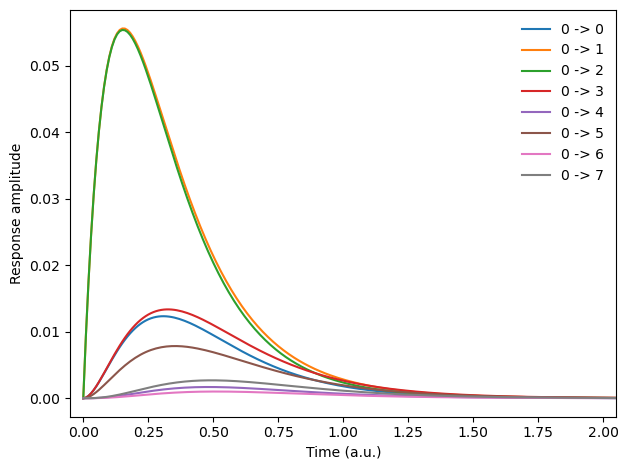

In [4]:
# Visualise the temporal evolution of the responses from i=1 to all other nodes
plt.figure()
for j in range(N):
    plt.plot(tpoints, resps[:,0,j], label='0 -> %d' %j)
plt.xlim(-0.05,2.05)
plt.xlabel('Time (a.u.)');
plt.ylabel('Response amplitude')
plt.legend(frameon=False)
plt.tight_layout()

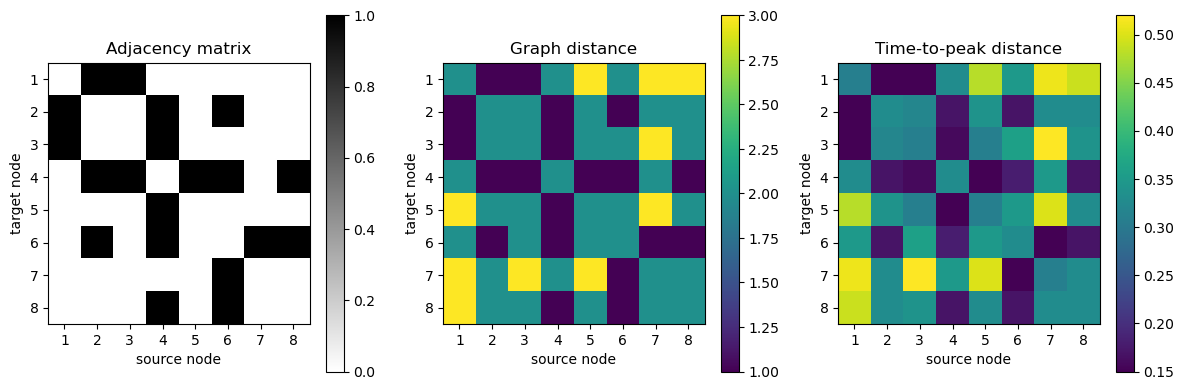

In [5]:
# Compute the classical graph distance
dist = galib.FloydWarshall(net)

# Compute the time-to-peak distance
ttp = sna.Time2Peak(resps, timestep=dt)

plt.figure(figsize=(12,4))
# Plot the adjacency matrix
plt.subplot(1,3,1)
plt.title('Adjacency matrix')
plt.imshow(net, cmap='gray_r')
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')

# Plot the classical graph distance
plt.subplot(1,3,2)
plt.title('Graph distance')
plt.imshow(dist)
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')

# Plot the time-2-peak distance matrix
plt.subplot(1,3,3)
plt.title('Time-to-peak distance')
plt.imshow(ttp)
plt.colorbar()
plt.xticks(np.arange(N), np.arange(N)+1)
plt.yticks(np.arange(N), np.arange(N)+1)
plt.xlabel('source node')
plt.ylabel('target node')

plt.tight_layout()

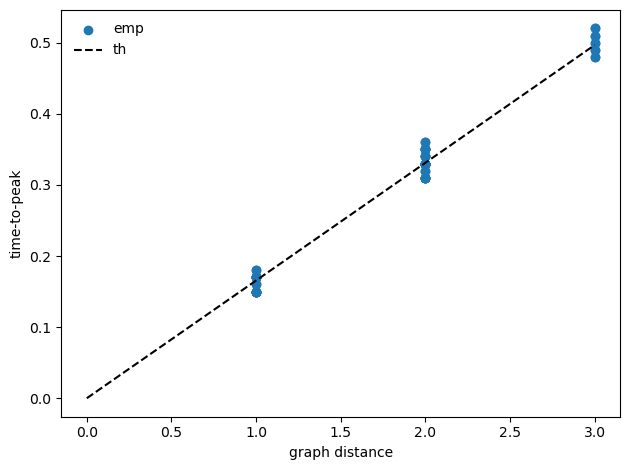

In [6]:
# Plot the time-2-peak distance matrix
plt.figure()
plt.scatter(dist, ttp, label='emp')
plt.plot(np.arange(4), np.arange(4)*(tau/maxtau)/np.exp(1), '--k', label='th') # theoretical fit
plt.xlabel('graph distance')
plt.ylabel('time-to-peak')
plt.legend(frameon=False)
plt.tight_layout()

As seen, pairs of nodes connected by a direct links are also the ones at shortest time-to-peak. Also, the time-to-peak is linearly correlated to the graph distance, except for the diagonal elements of the matrix. In fact, the time-to-peak corresponds to a path of length 

## 2. Comparing distances in common graph models

We now validate the relation between classical graph distance and time-to-peak (for binary networks) in three popular graph models: random graphs (uniform probability), scale-free-like networks and ring lattices. We now
* generate some random, scale-free and regular networks,
* choose a time-constant,
* evaluate the time-to-peak metric for all node pairs and
* compare it with the graph geodesic distance.

In [9]:
# Set the size, density and number of links for the networks
N = 100
dens = 0.1
L = int( round(0.5*dens*N*(N-1)))

# Generate the networks. They all have same number of links
randnet = galib.models.RandomGraph(N,L, directed=False)
sfnet = galib.models.ScaleFreeGraph(N,L, exponent=2.5, directed=False)
ringnet = galib.models.Lattice1D_FixLinks(N,L)

# Calculate their spectral radii
# For the random graph 
evs = np.linalg.eigvals(randnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = np.real(evs[i])
evmax_rand = evsnorms.max()
maxtau_rand = 1./evmax_rand

# For the scale-free graph
evs = np.linalg.eigvals(sfnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = np.real(evs[i])
evmax_sf = evsnorms.max()
maxtau_sf = 1./evmax_sf

# For the ring lattice 
evs = np.linalg.eigvals(ringnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = np.real(evs[i])
evmax_ring = evsnorms.max()
maxtau_ring = 1./evmax_ring


print( 'RANDOM:     λmax = %3.5f  τmax = %3.5f' %(evmax_rand, maxtau_rand) )
print( 'SCALE-FREE: λmax = %3.5f  τmax = %3.5f' %(evmax_sf, maxtau_sf) )
print( 'RING LATT:  λmax = %3.5f  τmax = %3.5f' %(evmax_ring, maxtau_ring) )

RANDOM:     λmax = 10.75192  τmax = 0.09301
SCALE-FREE: λmax = 15.06923  τmax = 0.06636
RING LATT:  λmax = 9.95968  τmax = 0.10040


In [12]:
# Set a time-constant
tau_rand = 0.4 * maxtau_rand
tau_sf = 0.4 * maxtau_sf
tau_ring = 0.4 * maxtau_ring

# Define the temporal resolution
tfinal = 1.0
dt = 0.001
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the evolution of the pair-wise responses, for the three models
resps_rand = sna.Resp_LeakyCascade(randnet, S0=1.0, tau=tau_rand, tmax=tfinal, timestep=dt, case='regressed')
resps_sf   = sna.Resp_LeakyCascade(sfnet,   S0=1.0, tau=tau_sf,   tmax=tfinal, timestep=dt, case='regressed')
resps_ring = sna.Resp_LeakyCascade(ringnet, S0=1.0, tau=tau_ring, tmax=tfinal, timestep=dt, case='regressed')

Plot the global network responses in the three cases

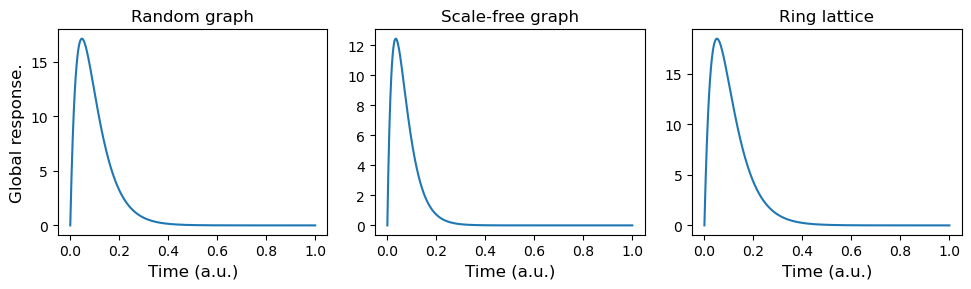

In [13]:
# Calculate the total communicability over time for the three networks
# Results 'totcom' are 1D numpy arrays of length nsteps
totresp_rand = sna.GlobalResponse(resps_rand)
totresp_sf =   sna.GlobalResponse(resps_sf)
totresp_ring = sna.GlobalResponse(resps_ring)

# Plot the results
plt.figure(figsize=(10,3))
# For the random graph
plt.subplot(1,3,1)
plt.title('Random graph', fontsize=12)
plt.plot(tpoints,totresp_rand)
#plt.ylim(-0.5,8)
plt.ylabel('Global response.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

# For the scale-free graph
plt.subplot(1,3,2)
plt.title('Scale-free graph', fontsize=12)
plt.plot(tpoints,totresp_sf)
#plt.ylim(-0.5,8)
#plt.ylabel('Total Communic.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

# For the ring lattice
plt.subplot(1,3,3)
plt.title('Ring lattice', fontsize=12)
plt.plot(tpoints,totresp_ring)
#plt.ylim(-0.5,8)
#plt.ylabel('Total Communic.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

plt.tight_layout()

In [14]:
# Calculate the usual graph distance matrices for the three networks
dij_rand = galib.FloydWarshall(randnet)
dij_sf = galib.FloydWarshall(sfnet)
dij_ring = galib.FloydWarshall(ringnet)

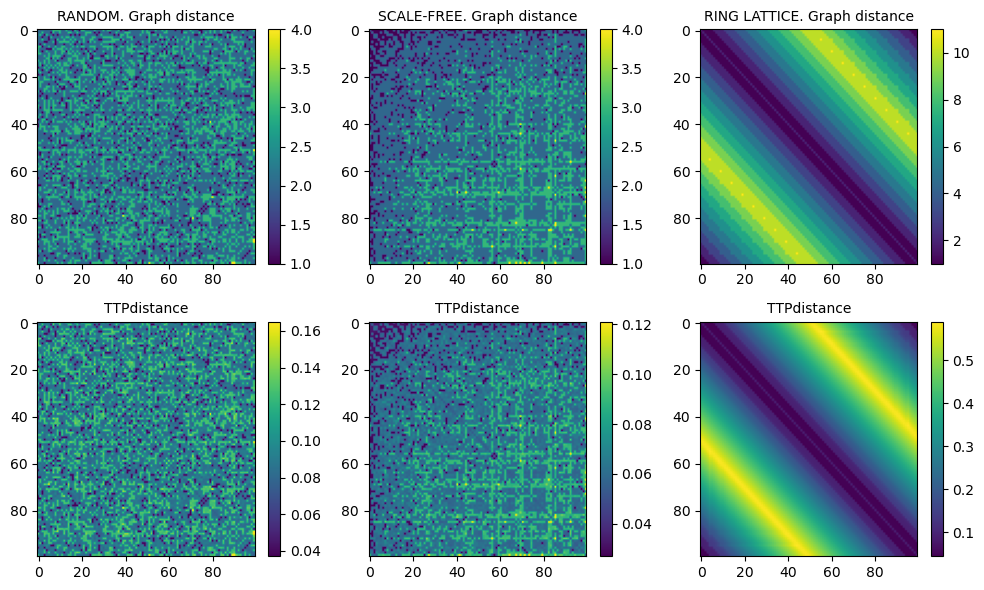

In [16]:
# Calculate now the TTPdistance for the three networks
ttpdist_rand = sna.Time2Peak(resps_rand, dt)
ttpdist_sf =   sna.Time2Peak(resps_sf, dt)
ttpdist_ring = sna.Time2Peak(resps_ring, dt)


# Plot the classical graph distances
plt.figure(figsize=(10,6))
# Random graphs
plt.subplot(2,3,1)
plt.title('RANDOM. Graph distance', fontsize=10)
plt.imshow(dij_rand, aspect='auto')
plt.colorbar()

plt.subplot(2,3,4)
plt.title('TTPdistance', fontsize=10)
plt.imshow(ttpdist_rand, aspect='auto')
plt.colorbar()

# Scale-free graphs
plt.subplot(2,3,2)

plt.title('SCALE-FREE. Graph distance', fontsize=10)
plt.imshow(dij_sf, aspect='auto')
plt.colorbar()

plt.subplot(2,3,5)
plt.title('TTPdistance', fontsize=10)
plt.imshow(ttpdist_sf, aspect='auto')
plt.colorbar()

# Ring-lattices
plt.subplot(2,3,3)
plt.title('RING LATTICE. Graph distance', fontsize=10)
plt.imshow(dij_ring, aspect='auto')
plt.colorbar()

plt.subplot(2,3,6)
plt.title('TTPdistance', fontsize=10)
plt.imshow(ttpdist_ring, aspect='auto')
plt.colorbar()

plt.tight_layout()

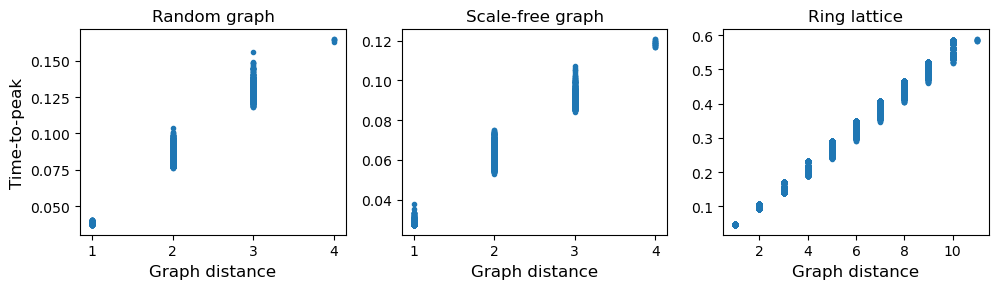

In [17]:
# Compare the pair-wise distances
# Consider only the upper triangular elements
triuidx = np.triu_indices(N,k=1)

plt.figure(figsize=(10,3))
# Relation for random graphs
plt.subplot(1,3,1)
plt.title('Random graph', fontsize=12)
plt.plot(dij_rand[triuidx], ttpdist_rand[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
plt.ylabel('Time-to-peak', fontsize=12)

# Relation for scale-free graphs
plt.subplot(1,3,2)
plt.title('Scale-free graph', fontsize=12)
plt.plot(dij_sf[triuidx], ttpdist_sf[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
#plt.ylabel('Time-to-peak', fontsize=12)

# Relation for ring-lattices graphs
plt.subplot(1,3,3)
plt.title('Ring lattice', fontsize=12)
plt.plot(dij_ring[triuidx], ttpdist_ring[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
#plt.ylabel('Time-to-peak', fontsize=12)

plt.tight_layout()